In [1]:
#Helper Functions for Data processing:

import pandas as pd
import numpy as np
import geopandas as gpd
import dask 
import numba
import libpysal as lp
from rasterstats import zonal_stats
import os
import rasterio
from pathlib import Path
import json
from rasterio.mask import mask



/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def read_spatial(path, espg_code):
    '''
    Function to read spatial data and converts to ESPG 3435
    Input: path to the data file
            epgs_code (string): epsg code as a string
    Output: a gpd object 
    '''
    epsg = "EPSG:" + espg_code
    file=gpd.read_file(path)
    file=file.to_crs(epsg)
    print(path, file.crs)
    return file

data/com_areas_chi EPSG:32616


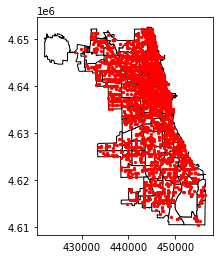

In [75]:
#GET TOY TEST DATA:
com_areas = read_spatial("data/com_areas_chi", "32616")
bike_rack_points = pd.read_csv('data/Bike_Racks.csv')
bike_rack_points = bike_rack_points.rename(columns = {"LOCATION":"geometry"})
bike_racks = gpd.GeoDataFrame(
    bike_rack_points, geometry=gpd.points_from_xy(bike_rack_points.Longitude,
                                                  bike_rack_points.Latitude), 
    crs="EPSG:4326")
bike_racks = bike_racks.to_crs("EPSG:32616")
bike_racks = bike_racks[["RackID", "Address", "F12", "F13", "geometry"]]
bike_racks["F12"] = bike_racks["F12"].round(1)
bike_racks["F13"] = bike_racks["F13"].round(1)
base = com_areas.plot(color='white', edgecolor='black')
bike_racks.plot(ax=base, marker='o', color='red', markersize=5);

In [5]:
def conduct_point_to_polygon(polygon_data, poly_unique_id, other_file):
    '''
    A function that creates a new dataset with spatial join of pyolgon data to points
    Inputs:
        polygon_data (gpd): polygon data (i.e. Community Areas)
        poly_unique_id (list of strings): the unique identifiers of the polygon spatial data
        other_file (gpd): another point-based gpd. Data from this will be aggregated 
                          to the polygon scale
        agg_dict (dict keys: strings - col names in point data
                       values: strings or list of strings - how to aggregate)
                       
    Output:
        the polygon_data dataframe updated with the new column
    Note: .size suggestion from here: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    '''
    spatial_join = gpd.sjoin(other_file, 
                             polygon_data[poly_unique_id + ["geometry"]], 
                             how="inner", 
                             op='intersects')
    
    return spatial_join
#USE CASE: 
#INPUT com areas and point data with all of the ND.. features
#We get the com area the point data is in


In [8]:
#Toy Test:
bike_ag_dict = {'RackID': ['min', 'max'], 'Address': 'size'}

com_area_w_bike = conduct_point_to_polygon(com_areas, 
                                           ["community", "area_numbe"], 
                                           bike_racks)
com_area_w_bike

,RackID,Address,F12,F13,geometry,index_right,community,area_numbe
0,3492,1391 N Milwaukee Ave,41.9,-87.7,POINT (1164227.030 1909454.074),24,WEST TOWN,24
2,5945,1001 N Damen Ave,41.9,-87.7,POINT (1162920.382 1906709.783),24,WEST TOWN,24
9,483,1943 W North Ave,41.9,-87.7,POINT (1163003.301 1910601.713),24,WEST TOWN,24
15,4118,1147 N Western Ave,41.9,-87.7,POINT (1160251.418 1907653.047),24,WEST TOWN,24
29,6518,2222 W North Ave,41.9,-87.7,POINT (1161205.566 1910644.139),24,WEST TOWN,24
...,...,...,...,...,...,...,...,...
4856,5419,6566 N Avondale Ave,42.0,-87.8,POINT (1125123.306 1942869.087),76,EDISON PARK,9
4921,3616,6700 N Olmsted Ave,42.0,-87.8,POINT (1124580.663 1943783.780),76,EDISON PARK,9
5056,3589,6755 N Northwest Highway Hwy,42.0,-87.8,POINT (1124321.999 1944489.194),76,EDISON PARK,9
4422,4492,9130 S University Ave,41.7,-87.6,POINT (1185424.432 1844638.524),42,BURNSIDE,47


In [9]:
def agg_cell_data(df, cols_to_group_by, ag_dict):
    '''
    Function to aggregate point weather data the cols_to_group_by and perform aggregations
    as specificed in the aggregation_dictionary
    Inputs:
        df the dataframe
        cols_to_group_by (list of strings): columns in df
        ag_dict (dictionary of strings to list of strings): maps column names to 
                                    aggregation operations
    Outputs:
        aggregated df
    '''
    df_new = df.groupby(cols_to_group_by).agg(ag_dict)
    
    return df_new

#USE CASE: ONCE WE HAVE PREVIOUS DATA, WE GROUP BY COM AREA, PERIOD, YEAR
# THEN WE AGGREGATE: MEAN, MAX OF DIFFERENT ND.. COLS


In [10]:
cols = ["area_numbe", "F12"]
ag_dict1 = {"RackID":"mean", "F13": ["min", "max"]}
bike_rack_agg = agg_cell_data(com_area_w_bike, cols_to_group_by = cols, 
                             ag_dict = ag_dict1)
bike_rack_agg


RackID   F13      
                        mean   min   max
area_numbe F12                          
1          42.0  3457.823529 -87.7 -87.7
10         42.0  3865.415385 -87.8 -87.8
11         42.0  3822.250000 -87.8 -87.8
12         42.0  2975.440000 -87.8 -87.7
13         42.0  3948.485714 -87.7 -87.7
...                      ...   ...   ...
75         41.7  4107.976744 -87.7 -87.6
76         42.0  2381.750000 -87.8 -87.8
77         42.0  3398.801653 -87.7 -87.7
8          41.9  3801.804965 -87.7 -87.6
9          42.0  3667.050000 -87.8 -87.8

[92 rows x 3 columns]

In [42]:
#Get raster data:
SHARED_DATA_FOLDER = Path('tif_data_2021')
#construct SCENE NAME
# path_row = []  
# year = []
# month = []
# day = []
SCENE = 'LC08_L2SP_022031_20210514_20210525_02_T1'
#check if scene_path is a file
scene_path = SHARED_DATA_FOLDER/SCENE
b1_path =scene_path/"{}_SR_B2.TIF".format(SCENE)
b1 = rasterio.open(b1_path)
chi_b = gpd.read_file("chi_b")
chi_b = chi_b.to_crs("EPSG:32616")




In [82]:
b1 = rasterio.open(b1_path)

In [99]:
b1.crs

CRS.from_epsg(32616)

In [53]:
def clip_raster(raster, vector_poly):
    '''
    Clip raster polygon with the vecotr polygon boundary
    Input: 
        raster - rasterio object (i.e. read from rasterio.open)
        vector_poly - geopandas dataframe
    Output:
        raster object that is clipped
    '''
    vector_poly_good_crs = vector_poly.to_crs(raster.crs)
    vector_as_json = [json.loads(vector_poly.to_json())['features'][0]['geometry']]
    
    out_img, out_transform = mask(dataset=raster, 
                                  shapes=vector_as_json, 
                                  crop=True)
    return out_img, out_transform
    
    

In [199]:
new_raster, new_raster_transform = clip_raster(b1, chi_b)

In [161]:
import sys 
np.set_printoptions(threshold=1000)


In [33]:
def compute_spatial_lag(gpd, column, new_col_name, time_indentifier):
    '''
    Creates a new column in the dataframe that calculates the spatial lag
    Spatial lag defined as the average of the neighbors
    Neighbors are defined using first order queen contiguity
    
    Inputs:
        gpd - a geopandas dataframe
        column - the column on which to create the spatial lag
        new_col_name - the name of the spatial lag column
        time-identifier - a column that identifies the time periods
            in the data
    Ouput:
        gpd - the updated dataframe with the new columns
    
    '''        
    weights_matrix = lp.weights.Queen.from_dataframe(gpd)
    weights_matrix.transform = "r"
    data_series = gpd[column]
    gpd[new_col_name] = lp.weights.lag_spatial(weights_matrix, 
                                                          gpd[column])
    return gpd

In [88]:
com_w_weighted_area = compute_spatial_lag(com_areas, "shape_area", "lag_shape_len", "time")

In [130]:
com_w_weighted_area[com_w_weighted_area["area_numbe"] == "2"]

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,lag_shape_area,lag_shape_len
19,0.0,2,2,0.0,0.0,WEST RIDGE,0.0,9.842909e+07,43020.689458,"POLYGON ((443315.818 4652166.308, 443316.880 4...",6.033773e+07,6.033773e+07


In [193]:
def compute_max(list_of_arrays):
    '''
    Function that computes the elementwise max of the arrays in the list of arrays
    Inputs:
        list_of_arrays (list of 1D np arrays), note the arrays should be the same size
    Output:
        max_array (1D np array): the elementwise max from each array
    '''
    max_array = np.maximum(*list_of_arrays)
    return max_array
#a = np.array([[1, 2], [4, -1]])    
#b = np.array([[-1, 5], [0, 1]])
#compute_max([a, b])

In [254]:
#Read and set community areas up: 
com_areas = read_spatial("data/com_areas_chi", "32616")
com_areas2 = com_areas[["area_numbe", "community", "geometry"]]
#com_areas3 = com_areas2[com_areas2[:, 0].argsort()]
#com_areas2
com_areas2["number"] = pd.to_numeric(com_areas_no_spatial["area_numbe"])
com_areas3 = com_areas2.sort_values(by=["number"])
com_areas3 #This is the com areas to use

com_areas_no_spatial = com_areas3[["area_numbe", "community", "number"]]

data/com_areas_chi EPSG:32616


/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [255]:
test = com_areas_no_spatial[["number"]]
test["n2"] = test["number"]*2

<ipython-input-255-41194163f2f2>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test = com_areas_no_spatial[["number"]]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [278]:
test = np.array(test)
test

array([[  1,   2],
       [  2,   4],
       [  3,   6],
       [  4,   8],
       [  5,  10],
       [  6,  12],
       [  7,  14],
       [  8,  16],
       [  9,  18],
       [ 10,  20],
       [ 11,  22],
       [ 12,  24],
       [ 13,  26],
       [ 14,  28],
       [ 15,  30],
       [ 16,  32],
       [ 17,  34],
       [ 18,  36],
       [ 19,  38],
       [ 20,  40],
       [ 21,  42],
       [ 22,  44],
       [ 23,  46],
       [ 24,  48],
       [ 25,  50],
       [ 26,  52],
       [ 27,  54],
       [ 28,  56],
       [ 29,  58],
       [ 30,  60],
       [ 31,  62],
       [ 32,  64],
       [ 33,  66],
       [ 34,  68],
       [ 35,  70],
       [ 36,  72],
       [ 37,  74],
       [ 38,  76],
       [ 39,  78],
       [ 40,  80],
       [ 41,  82],
       [ 42,  84],
       [ 43,  86],
       [ 44,  88],
       [ 45,  90],
       [ 46,  92],
       [ 47,  94],
       [ 48,  96],
       [ 49,  98],
       [ 50, 100],
       [ 51, 102],
       [ 52, 104],
       [ 53,

In [283]:
def get_W(com_areas):
    '''
    Function that takes community areas shapefile (should be sorted by area number)
    Input:
        com_areas (gpd): a community areas shapefile sorted by area number
    Output:
        W (2D np.array): the spatial weights matrix
    
    '''
    #Get pysal weights matrix:
    weights_matrix = lp.weights.Queen.from_dataframe(com_areas, idVariable='area_numbe')

    #Access their dictionary
    w_dict = weights_matrix.neighbors
    W = np.zeros((77, 77))

    for com_area, list_of_neighbors in w_dict.items():
        for neighbor in list_of_neighbors:
            W[int(com_area) -1, int(neighbor) -1] = 1

    #Standardize:
    sum_of_rows = W.sum(axis=1)
    W = W / sum_of_rows[:, np.newaxis]
    
    return W

#W = get_W(com_areas3)

In [279]:
def compute_spatial_lag(data_array, W):
    '''
    Computes the first order queen contiguity spatial lag for data in the data_array given weights matrix W
    Inputs:
        data_array (2D np.array): data matrix with rows indicating community areas (ordered by com area number)
        W (2D np.array): a spatial weights matrix of size 77 x 77
    Outputs:
        data_array (2D np.array): the data array, but with columns appended for each spatial lag
    '''
    n, p = data_array.shape
    new_data_array = data_array
    
    for i in range(p):
        col = data_array[:,i]
        lag = W @ col
        lag = lag.reshape(-1, 1)
        new_data_array = np.hstack((new_data_array, lag))
    return new_data_array 

out = compute_spatial_lag(test, W)



In [280]:
out.shape

(77, 4)

In [277]:
out[:,2]

array([39.5       , 23.75      , 23.        , 17.        , 11.625     ,
        4.75      , 13.        , 22.75      , 10.        , 27.        ,
       12.33333333, 13.16666667,  8.        , 10.83333333, 15.57142857,
       13.        , 32.        , 20.33333333, 19.66666667, 20.14285714,
       15.75      , 16.66666667, 23.28571429, 19.16666667, 22.5       ,
       26.        , 26.        , 27.25      , 27.83333333, 48.33333333,
       41.375     , 23.        , 32.        , 37.42857143, 35.25      ,
       37.33333333, 50.16666667, 37.42857143, 38.75      , 47.71428571,
       39.75      , 48.25      , 50.5       , 54.83333333, 49.5       ,
       47.8       , 47.83333333, 46.6       , 58.375     , 50.25      ,
       50.28571429, 50.66666667, 59.33333333, 51.6       , 52.33333333,
       55.6       , 51.5       , 51.85714286, 48.        , 44.4       ,
       58.85714286, 60.5       , 63.16666667, 61.        , 63.5       ,
       67.2       , 65.8       , 57.5       , 50.42857143, 68.5 

In [248]:
W @ com_areas_no_spatial["number"]

array([39.5       , 23.75      , 23.        , 17.        , 11.625     ,
        4.75      , 13.        , 22.75      , 10.        , 27.        ,
       12.33333333, 13.16666667,  8.        , 10.83333333, 15.57142857,
       13.        , 32.        , 20.33333333, 19.66666667, 20.14285714,
       15.75      , 16.66666667, 23.28571429, 19.16666667, 22.5       ,
       26.        , 26.        , 27.25      , 27.83333333, 48.33333333,
       41.375     , 23.        , 32.        , 37.42857143, 35.25      ,
       37.33333333, 50.16666667, 37.42857143, 38.75      , 47.71428571,
       39.75      , 48.25      , 50.5       , 54.83333333, 49.5       ,
       47.8       , 47.83333333, 46.6       , 58.375     , 50.25      ,
       50.28571429, 50.66666667, 59.33333333, 51.6       , 52.33333333,
       55.6       , 51.5       , 51.85714286, 48.        , 44.4       ,
       58.85714286, 60.5       , 63.16666667, 61.        , 63.5       ,
       67.2       , 65.8       , 57.5       , 50.42857143, 68.5 

In [247]:
 com_areas_no_spatial["number"]

9      1
19     2
30     3
5      4
47     5
      ..
71    73
72    74
73    75
74    76
75    77
Name: number, Length: 77, dtype: int64

In [145]:
def compute_zonal_stats(path_to_raster, vector, band_name):
    '''
    Inputs: 
        path_to_raster (string): path to raster data
        vector (geopandas df): 
        band_name (string): name of band
    Outputs:
        nparray (1D np array): mean values of the raster data 
                             ordered by com area order
    '''
    col_name = "mean_" + band_name
    sum_stats = zonal_stats(vector, file, 
                            # nodata = Nan,
                            stats=["mean"])
    print(sum_stats)
    df = pd.DataFrame(sum_stats)
    print(df)
    df = df.rename(columns = {"mean": col_name})
    nparray = np.array(df)
    
    return nparray


file = "../data_2013_2015/LC08_L2SP_022031_20130524_20200913_02_T1/LC08_L2SP_022031_20130524_20200913_02_T1_SR_B1.TIF"
a = compute_zonal_stats(file, com_areas2, "b1")
print(a.shape, a)


[{'mean': 10530.797393862968}, {'mean': 10434.438955139125}, {'mean': 10824.887972841902}, {'mean': 10625.19534697152}, {'mean': 10452.619765494137}, {'mean': 10316.13923013923}, {'mean': 9973.613132006405}, {'mean': 10499.618115318417}, {'mean': None}, {'mean': 11256.966968667422}, {'mean': 10234.967129837143}, {'mean': 9324.507578235743}, {'mean': None}, {'mean': 10595.425144300145}, {'mean': 10325.482743440747}, {'mean': 10479.234815618222}, {'mean': 10003.07959546774}, {'mean': 10208.49629106323}, {'mean': 10619.792479602696}, {'mean': 10533.557448065374}, {'mean': 10655.713774597496}, {'mean': 11124.941124780316}, {'mean': None}, {'mean': 10831.789869029275}, {'mean': 10998.76577605237}, {'mean': 10433.435006810663}, {'mean': None}, {'mean': 10582.6869251578}, {'mean': None}, {'mean': 10602.13388804841}, {'mean': None}, {'mean': 10747.255312689738}, {'mean': 11194.639225469233}, {'mean': 11422.425092538477}, {'mean': 11060.456833275079}, {'mean': 9952.80006362335}, {'mean': 10677.